<div align="center">

## SkyFare Insights: Precision Flight Price Predictor

</div>

![Flight_wallpaper](flight_wallpaper.jpg)

**Project Objective**

> The goal of this project is to build a reliable, end‑to‑end machine learning solution that can accurately predict airline ticket prices based on journey details (such as origin, destination, departure time, and number of stops), temporal factors (seasonality, day of week, hour of departure), and engineered features (flight duration, route complexity). By uncovering key drivers of fare variation and capturing both linear and non‑linear relationships, our model will enable travelers to estimate expected costs and help airlines fine‑tune dynamic pricing strategies.


| Feature               | Type        | Description                                                                                 |
| --------------------- | ----------- | ------------------------------------------------------------------------------------------- |
| **Airline**           | Categorical | Carrier name (e.g. IndiGo, Air India, SpiceJet). Encoded via one‑hot or target encoding.    |
| **Source**            | Categorical | Departure city (e.g. Delhi, Mumbai). Captures origin‑based pricing differences.             |
| **Destination**       | Categorical | Arrival city (e.g. Bengaluru, Kolkata). Reflects demand and competition on each route.      |
| **Date\_of\_Journey** | Datetime    | Original journey date (dd/mm/yyyy). Used to extract temporal features below.                |
| **Travel\_Day**       | Numeric     | Day of the month (1–31).                                                                    |
| **Travel\_Month**     | Numeric     | Month of the year (1–12).                                                                   |
| **Travel\_Weekday**   | Numeric     | Day of week (0 = Monday … 6 = Sunday). Captures weekday vs. weekend pricing patterns.       |
| **Dep\_Time**         | Numeric     | Hour of departure (0–23). Indicates peak/off‑peak travel times.                             |
| **Arrival\_Time**     | Numeric     | Hour of arrival (0–23). May correlate with premium schedules (red‑eye, business hours).     |
| **Duration\_mins**    | Numeric     | Total flight duration in minutes. Engines non‑linear effects of longer vs. shorter flights. |
| **Total\_Stops**      | Numeric     | Number of stops (0 = non‑stop, 1, 2, …). Longer itineraries often cost less per leg.        |
| **Route**             | Categorical | Full stop‑sequence (e.g. “DEL → BOM → BLR”). Optionally parsed or aggregated into patterns. |
| **Additional\_Info**  | Categorical | Extra notes (e.g. “no info”, “Change airports”). Encodes special‑case pricing details.      |
| **Price**             | Numeric     | Target variable—ticket price in local currency.                                             |


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from scipy import stats
from IPython.display import display

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
import warnings
warnings.filterwarnings('ignore')

In [2]:
sns.set_theme(
    style="darkgrid",
    rc={
        "figure.facecolor": "black",
        "axes.facecolor":   "black",
        "axes.edgecolor":   "white",
        "grid.color":       "gray",
        "grid.linestyle":   "--",
        "grid.linewidth": "0.4",
        "text.color":       "white",
        "axes.labelcolor":  "white",
        "axes.titlecolor":  "white",
        "xtick.color":      "white",
        "ytick.color":      "white",
        "legend.facecolor": "#222222",
        "legend.edgecolor": "white",
        "legend.title_fontsize": "medium",
    }
)

mpl.rcParams.update({
    "savefig.facecolor": "black",
    "savefig.edgecolor": "black",
    "figure.edgecolor":  "black",
    "lines.linewidth":   2,
    "lines.markersize":  6,
})

def style_df(df):
    """Apply professional theme colors to pandas DataFrames."""
    styles = [
        {'selector': 'th', 'props': [('background-color', 'darkcyan'), ('color', 'white'), ('font-weight', 'bold')]},
        {'selector': 'td', 'props': [('background-color', '#e6f7f7'), ('color', '#101010')]}
    ]
    return df.style.set_table_styles(styles).set_properties(**{'border': '1px solid #101010'})

In [3]:
train_df = pd.read_csv("Train_Data.csv")
test_df = pd.read_csv("Test_Data.csv")

In [4]:
display(style_df(train_df.head(10)))

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR ? DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU ? IXR ? BBI ? BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL ? LKO ? BOM ? COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU ? NAG ? BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR ? NAG ? DEL,16:50,21:35,4h 45m,1 stop,No info,13302
5,SpiceJet,24/06/2019,Kolkata,Banglore,CCU ? BLR,09:00,11:25,2h 25m,non-stop,No info,3873
6,Jet Airways,12/03/2019,Banglore,New Delhi,BLR ? BOM ? DEL,18:55,10:25 13 Mar,15h 30m,1 stop,In-flight meal not included,11087
7,Jet Airways,01/03/2019,Banglore,New Delhi,BLR ? BOM ? DEL,08:00,05:05 02 Mar,21h 5m,1 stop,No info,22270
8,Jet Airways,12/03/2019,Banglore,New Delhi,BLR ? BOM ? DEL,08:55,10:25 13 Mar,25h 30m,1 stop,In-flight meal not included,11087
9,Multiple carriers,27/05/2019,Delhi,Cochin,DEL ? BOM ? COK,11:25,19:15,7h 50m,1 stop,No info,8625


In [5]:
display(style_df(test_df.head(10)))

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info
0,Jet Airways,6/06/2019,Delhi,Cochin,DEL ? BOM ? COK,17:30,04:25 07 Jun,10h 55m,1 stop,No info
1,IndiGo,12/05/2019,Kolkata,Banglore,CCU ? MAA ? BLR,06:20,10:20,4h,1 stop,No info
2,Jet Airways,21/05/2019,Delhi,Cochin,DEL ? BOM ? COK,19:15,19:00 22 May,23h 45m,1 stop,In-flight meal not included
3,Multiple carriers,21/05/2019,Delhi,Cochin,DEL ? BOM ? COK,08:00,21:00,13h,1 stop,No info
4,Air Asia,24/06/2019,Banglore,Delhi,BLR ? DEL,23:55,02:45 25 Jun,2h 50m,non-stop,No info
5,Jet Airways,12/06/2019,Delhi,Cochin,DEL ? BOM ? COK,18:15,12:35 13 Jun,18h 20m,1 stop,In-flight meal not included
6,Air India,12/03/2019,Banglore,New Delhi,BLR ? TRV ? DEL,07:30,22:35,15h 5m,1 stop,No info
7,IndiGo,1/05/2019,Kolkata,Banglore,CCU ? HYD ? BLR,15:15,20:30,5h 15m,1 stop,No info
8,IndiGo,15/03/2019,Kolkata,Banglore,CCU ? BLR,10:10,12:55,2h 45m,non-stop,No info
9,Jet Airways,18/05/2019,Kolkata,Banglore,CCU ? BOM ? BLR,16:30,22:35,6h 5m,1 stop,No info


In [6]:
print("Data Info:")
train_df.info()

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


In [7]:
print("Data Info:")
test_df.info()

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2671 entries, 0 to 2670
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          2671 non-null   object
 1   Date_of_Journey  2671 non-null   object
 2   Source           2671 non-null   object
 3   Destination      2671 non-null   object
 4   Route            2671 non-null   object
 5   Dep_Time         2671 non-null   object
 6   Arrival_Time     2671 non-null   object
 7   Duration         2671 non-null   object
 8   Total_Stops      2671 non-null   object
 9   Additional_Info  2671 non-null   object
dtypes: object(10)
memory usage: 208.8+ KB


<div align="center">

### Combine Train / Test data for uniform preprocessing

</div>

In [8]:
train_df['is_train'] = 1
test_df['is_train'] = 0

In [9]:
display(style_df(train_df.head(5)))
display(style_df(test_df.head(5)))

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,is_train
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR ? DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897,1
1,Air India,1/05/2019,Kolkata,Banglore,CCU ? IXR ? BBI ? BLR,05:50,13:15,7h 25m,2 stops,No info,7662,1
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL ? LKO ? BOM ? COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882,1
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU ? NAG ? BLR,18:05,23:30,5h 25m,1 stop,No info,6218,1
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR ? NAG ? DEL,16:50,21:35,4h 45m,1 stop,No info,13302,1


,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,is_train
0,Jet Airways,6/06/2019,Delhi,Cochin,DEL ? BOM ? COK,17:30,04:25 07 Jun,10h 55m,1 stop,No info,0
1,IndiGo,12/05/2019,Kolkata,Banglore,CCU ? MAA ? BLR,06:20,10:20,4h,1 stop,No info,0
2,Jet Airways,21/05/2019,Delhi,Cochin,DEL ? BOM ? COK,19:15,19:00 22 May,23h 45m,1 stop,In-flight meal not included,0
3,Multiple carriers,21/05/2019,Delhi,Cochin,DEL ? BOM ? COK,08:00,21:00,13h,1 stop,No info,0
4,Air Asia,24/06/2019,Banglore,Delhi,BLR ? DEL,23:55,02:45 25 Jun,2h 50m,non-stop,No info,0


In [10]:
df = pd.concat([train_df, test_df], axis=0, ignore_index=True)

In [11]:
display(style_df(df.head(5)))

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,is_train
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR ? DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897.000000,1
1,Air India,1/05/2019,Kolkata,Banglore,CCU ? IXR ? BBI ? BLR,05:50,13:15,7h 25m,2 stops,No info,7662.000000,1
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL ? LKO ? BOM ? COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882.000000,1
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU ? NAG ? BLR,18:05,23:30,5h 25m,1 stop,No info,6218.000000,1
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR ? NAG ? DEL,16:50,21:35,4h 45m,1 stop,No info,13302.000000,1


In [12]:
df.shape

(13354, 12)

In [13]:
train_df.shape

(10683, 12)

In [14]:
test_df.shape

(2671, 11)

In [15]:
df.isnull().sum()

Airline               0
Date_of_Journey       0
Source                0
Destination           0
Route                 1
Dep_Time              0
Arrival_Time          0
Duration              0
Total_Stops           1
Additional_Info       0
Price              2671
is_train              0
dtype: int64

In [16]:
df = df.dropna(subset= ['Route', 'Total_Stops'])

In [17]:
df.isnull().sum()

Airline               0
Date_of_Journey       0
Source                0
Destination           0
Route                 0
Dep_Time              0
Arrival_Time          0
Duration              0
Total_Stops           0
Additional_Info       0
Price              2671
is_train              0
dtype: int64

<div align="center">

### Summary Statistics

</div>

In [18]:
display(style_df(df.describe().T))

,count,mean,std,min,25%,50%,75%,max
Price,10682.000000,9087.214567,4611.548810,1759.000000,5277.000000,8372.000000,12373.000000,79512.000000
is_train,13353.000000,0.799970,0.400037,0.000000,1.000000,1.000000,1.000000,1.000000


In [19]:
skewed = stats.skew(df['Price'].dropna()).round(2)
print("Skewness of Price column:", skewed)

Skewness of Price column: 1.81


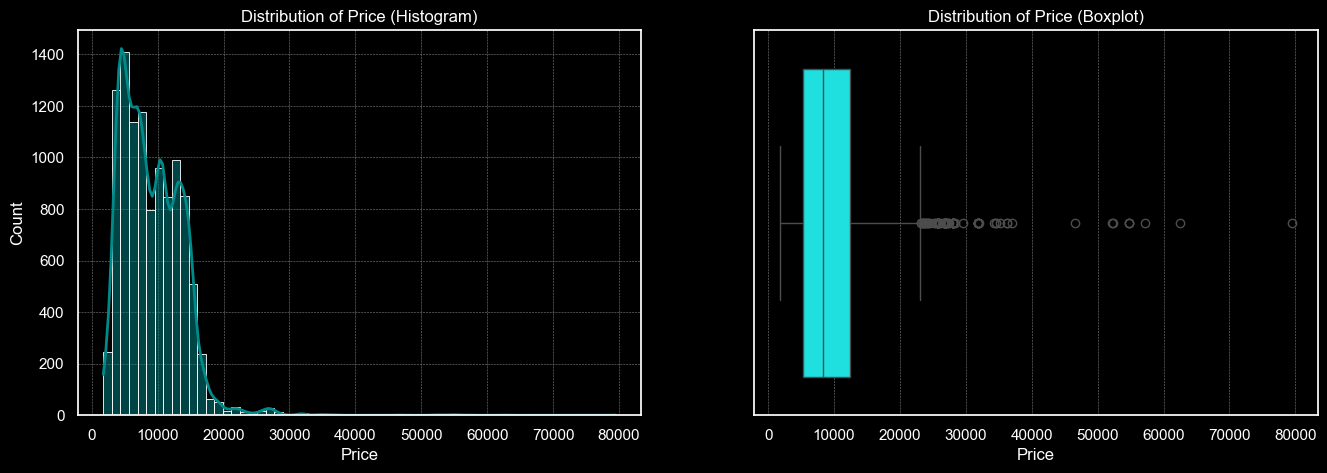

In [20]:
plt.figure(figsize= (16,5))
plt.subplot(121)
sns.histplot(df['Price'].dropna(), kde= True, color= 'darkcyan', bins= 60)
plt.title("Distribution of Price (Histogram)")

plt.subplot(122)
sns.boxplot(df['Price'].dropna(), color= 'cyan', orient='h')
plt.title("Distribution of Price (Boxplot)")

plt.show()

#### Log-transform skewed feature

In [21]:
df['Log_Price'] = np.log1p(df['Price'])

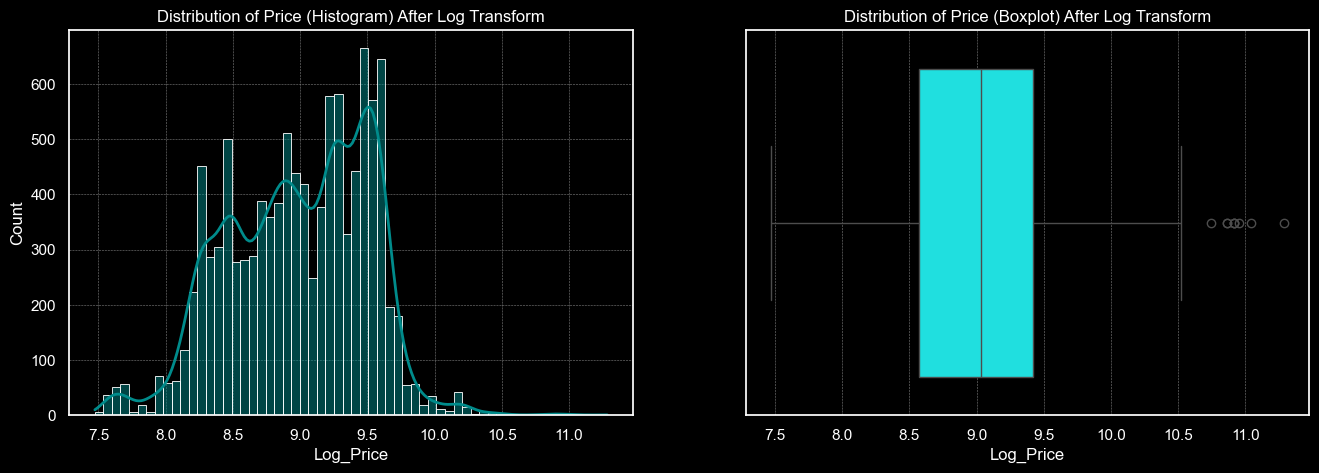

In [22]:
plt.figure(figsize= (16,5))
plt.subplot(121)
sns.histplot(df['Log_Price'].dropna(), kde= True, color= 'darkcyan', bins= 60)
plt.title("Distribution of Price (Histogram) After Log Transform")

plt.subplot(122)
sns.boxplot(df['Log_Price'].dropna(), color= 'cyan', orient='h')
plt.title("Distribution of Price (Boxplot) After Log Transform")

plt.show()

### Temporal Trends

In [23]:
df['Date_of_Journey'] = pd.to_datetime(df['Date_of_Journey'], format= '%d/%m/%Y')

In [24]:
df['Month_Period'] = df['Date_of_Journey'].dt.to_period('M')

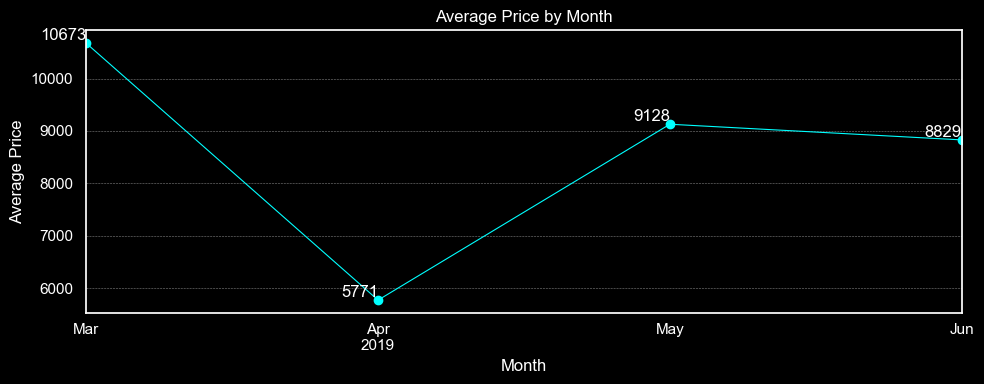

In [25]:
avg_price_month = df[df['is_train'] == 1].groupby('Month_Period')['Price'].mean()
plt.figure(figsize=(10,4))
ax = avg_price_month.plot(marker='o', linewidth=0.8, color='cyan')

for x, y in zip(avg_price_month.index.astype(str), avg_price_month.values):
    ax.text(
        x, y,
        f"{y:.0f}",
        ha='right',
        va='bottom',
        fontsize= 12
    )

plt.title("Average Price by Month")
plt.xlabel("Month")
plt.ylabel("Average Price")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Insights:

1. **Sharp peak in March (₹10,673)**

   * March shows the highest fares of the four‑month span—nearly double April’s. This could reflect end‑of‑fiscal travel surges, spring break demand, or even airline schedule reshuffles at quarter‑end.

2. **Dramatic trough in April (₹5,771)**

   * April dips to the lowest point, about 46% below March. It suggests a true “shoulder season” right after peak demand—ideal for budget‑conscious travelers.

3. **Rebound in May (₹9,128)**

   * Prices climb back up to roughly May‑level highs, indicating renewed demand, perhaps tied to summer holiday bookings kicking in or corporate travel ramping up before June.

4. **Slight softening in June (₹8,829)**

   * June remains elevated but is about 3.3% below May. Early summer demand still holds—but with a small mid‑season dip, possibly as families finalize plans or schools let out.

---

**Implications & Actions**

* **Dynamic Pricing Windows**

  * March & May: high‑demand windows—consider surcharges or premium offerings.
  * April: off‑peak promotional fares or bundled upsells (e.g. extra baggage, seat upgrades) to stimulate revenue.

* **Feature Engineering**

  * Encode month (or quarter) as a categorical or cyclical feature in your model—this strong seasonality is clearly predictive.
  * Consider creating a “peak vs off‑peak” binary flag to capture this April low.

* **Traveler Guidance**

  * For lowest prices, book travel in April.
  * If traveling in March or May, secure fares early or set price‑alerts to avoid late‑booking surcharges.


### Price by Day-of-week & Hour-of-day

In [26]:
df['Weekday'] = df['Date_of_Journey'].dt.weekday
df['Dep_Time'] = pd.to_datetime(df['Dep_Time'], format= '%H:%M').dt.hour

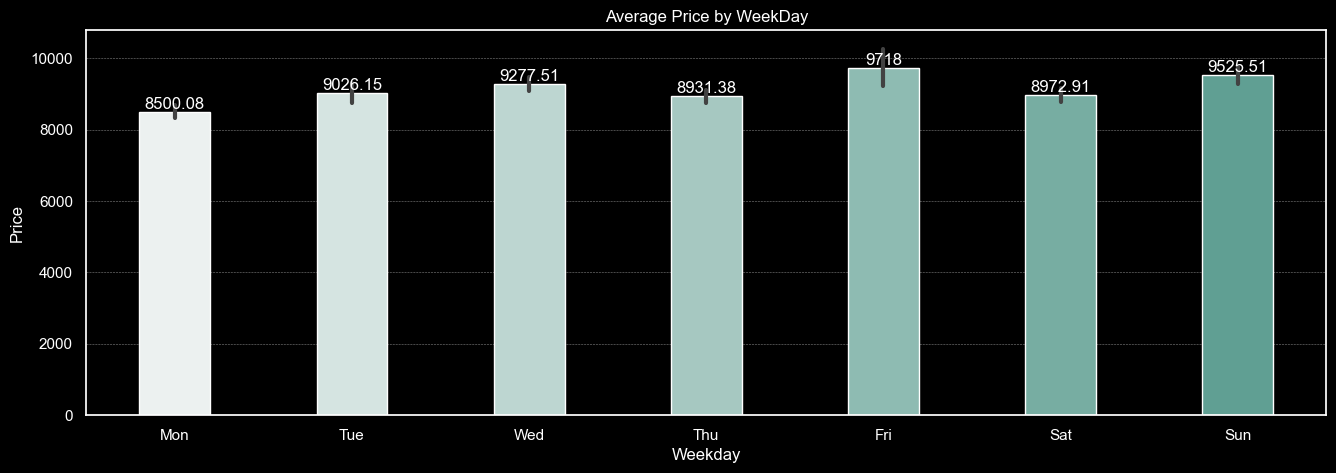

In [27]:
plt.figure(figsize=(16,5))
week_label = sns.barplot(
    x='Weekday', 
    y='Price', 
    data=df[df['is_train']==1], 
    palette='light:#5A9', 
    width=0.4
)
for i, container in enumerate(week_label.containers):
    week_label.bar_label(container)

week_label.set_xticklabels(
    ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
)

plt.title("Average Price by WeekDay")
plt.show()

#### Insights:

1. **Monday is the cheapest day to fly.**

   * With an average fare of ≈₹8,500, Mondays offer the lowest prices of the week—about 20% cheaper than the Friday peak.

2. **Friday sees the highest prices.**

   * At nearly ₹9,720 on average, Friday tickets are the priciest, likely driven by weekend‑bound travelers and business commuters.

3. **Sunday is the second‑most expensive.**

   * Sunday fares average around ₹9,525, suggesting strong leisure demand at the end of the weekend.

4. **Mid‑week hump on Wednesday.**

   * Wednesday (₹9,277) is noticeably more expensive than Tuesday (₹9,026) and Thursday (₹8,931). This could point to mid‑week business travel peaks or airline scheduling quirks.

5. **Variability trends.**

   * The error bars are largest on Friday and Sunday, indicating a wider spread of ticket prices (i.e. some flights are very expensive). Conversely, Monday and Thursday show tighter ranges.

---

**Actionable implications**

* **For travelers:** If you have flexibility, aim to fly (and even book) on Monday or Thursday to lock in the lowest average fares.
* **For modeling:**

  * Definitely include “day of week” as a feature—it has a strong non‑linear effect on price.
  * You may even bucket days into “cheap” (Mon/Thu), “mid” (Tue/Wed/Sat), and “expensive” (Fri/Sun) for simpler encoding.
* **For airlines:** Consider dynamic pricing strategies that anticipate these weekly demand cycles (e.g. special Monday deals, premium Friday surcharges).

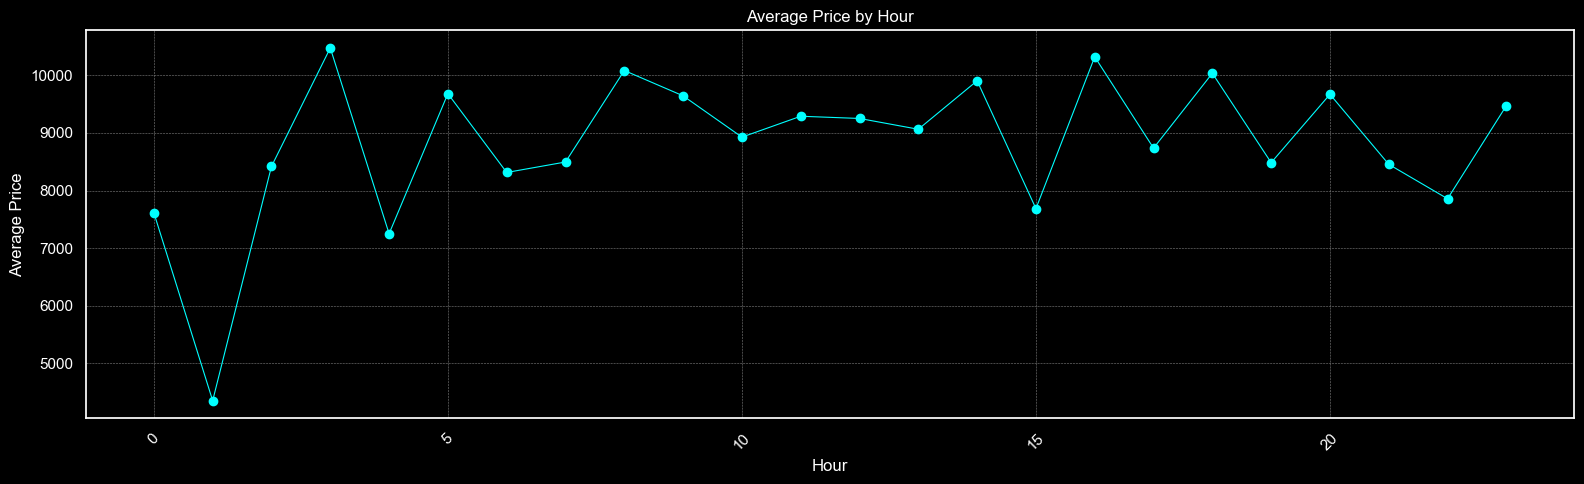

In [28]:
avg_price_hour = df[df['is_train'] == 1].groupby('Dep_Time')['Price'].mean()
plt.figure(figsize=(16,5))
ax = avg_price_hour.plot(marker='o', linewidth=0.8, color='cyan')
    
plt.title("Average Price by Hour")
plt.xlabel("Hour")
plt.ylabel("Average Price")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Insights:

1. **Deep‑off‑peak bargains at 1 AM (₹4,355)**

   * By far the cheapest slot—overnight flights clearly under‑demanded, making them budget‑friendly if you can handle red‑eye timing.

2. **Early‑morning surge (3 AM: ₹10,475 & 8 AM: ₹10,083)**

   * Unexpected spike at 3 AM may reflect a small number of premium‑priced repositioning or long‑haul departures;
   * The real morning peak at 8 AM aligns with business‑commuter schedules—airlines charge a premium for these highly in‑demand time windows.

3. **Midday stability (10–13 PM: \~₹8,900–₹9,300)**

   * Late‑morning to early‑afternoon flights hold moderate pricing—good compromise between cost and convenience.

4. **Afternoon secondary peak (4 PM: ₹10,320 & 6 PM: ₹10,036)**

   * A second business rush—late‑afternoon departures command rates similar to the morning peak.

5. **Evening & night moderate (20–23 PM: ₹9,470–₹9,670)**

   * After 8 PM prices dip slightly but remain above mid‑day levels, likely due to fewer but still steady leisure travelers.

---

**Key Takeaways & Actions**

* **Budget travelers** should target the 1 AM “red‑eye” or very early slots around 4 AM (₹7,251) for the lowest fares.
* **Business travelers** driving morning or late‑afternoon schedules should expect premium pricing—consider booking well in advance or using loyalty perks.
* **Modeling advice**: encode departure hour as a categorical or cyclical feature to capture these clear non‑linear demand peaks at 3 AM, 8 AM, 4 PM, and 6 PM.

### Categorical feature Analysis

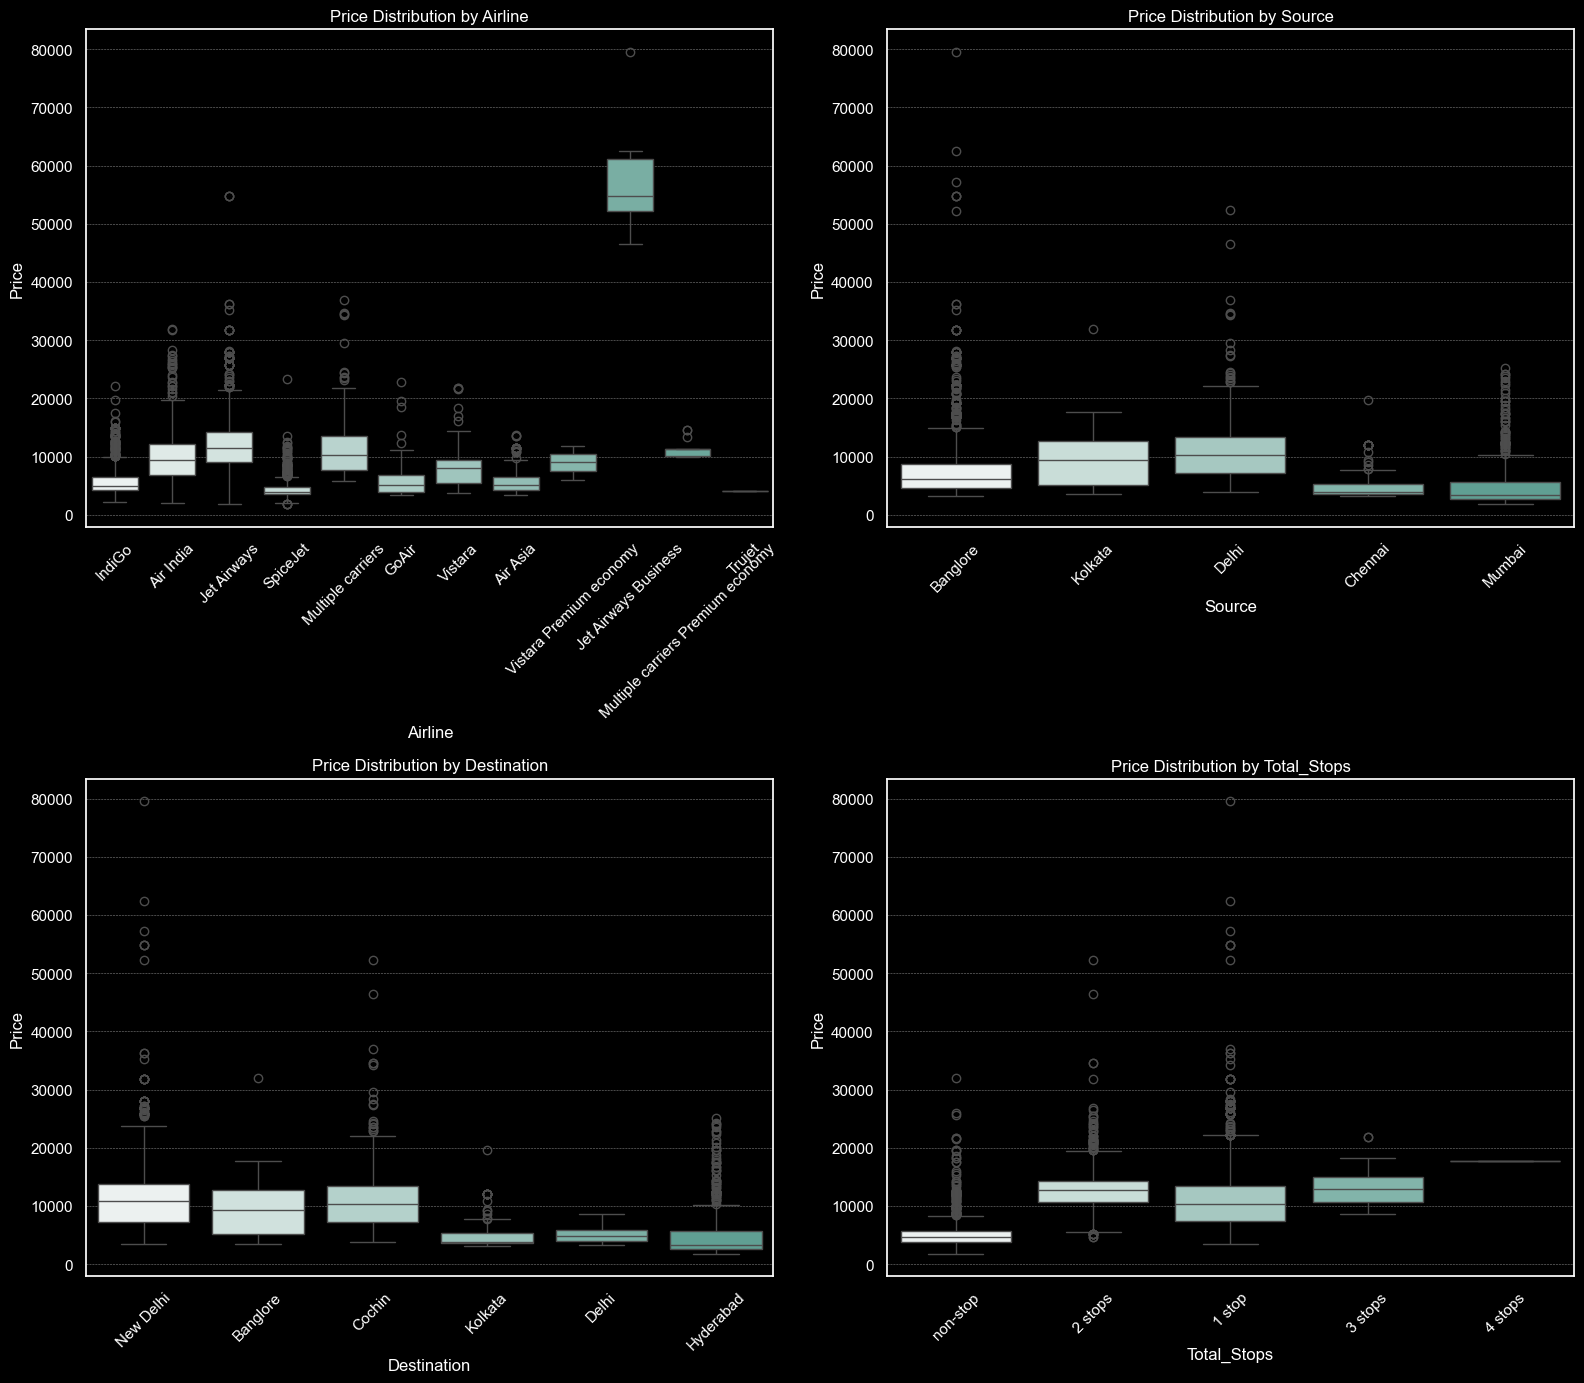

In [29]:
cat_cols = ['Airline', 'Source', 'Destination', 'Total_Stops']

plt.figure(figsize= (16,14))
for i,col in enumerate(cat_cols):
    plt.subplot(2,2,i+1)
    sns.boxplot(x= col, y= 'Price', data= df[df['is_train'] == 1], palette='light:#5A9')
    plt.xticks(rotation=45)
    plt.title(f"Price Distribution by {col}")
    
plt.tight_layout()
plt.show()

#### Insights: 
---

#### 1. By **Airline**

* **Low‑cost carriers** (IndiGo, SpiceJet, GoAir) have the lowest medians (\~₹5–8 K) and tighter IQRs—great for budget travelers.
* **Full‑service Indian carriers** (Air India, Vistara, Multiple carriers) sit in the mid‑range (\~₹9–15 K) but show wider spreads—occasionally they run high‑price premium flights.
* **Jet Airways Business** exhibit very high medians (₹50–60 K+) and extreme outliers—these reflect business‑class fares on multi‑leg itineraries.

> **Model tip:** Encode “carrier class” (budget vs. full‑service vs. premium) or use target‑encoding on Airline to capture these non‑linear effects.

---

#### 2. By **Source**

* **Kolkata & Delhi** departures skew higher (medians \~₹10–12 K), with occasional super‑expensive tickets (up to ₹80 K).
* **Bangalore & Mumbai** show moderate medians (\~₹7–8 K) but still retain high‑end outliers (₹60 K+).
* **Chennai** is consistently the cheapest origin (\~₹4–5 K median, low variance)—likely driven by fewer premium routes.

> **Business insight:** Travelers flying out of Chennai get the best baseline fares; airlines might bundle add‑ons to boost ancillary revenue there.

---

#### 3. By **Destination**

* **New Delhi & Cochin** are the priciest hubs (medians \~₹10–12 K), with top‐end peaks near ₹80 K.
* **Bangalore & Hyderabad** sit mid‑range (\~₹8–9 K) but have fatter tails (more variability).
* **Kolkata & Delhi (the second panel)**? Looks like a typo—if that panel was meant to be “Destination,” Chennai and others remain low‑cost.

> **Feature idea:** Capture origin–destination combinations as a single “route” categorical feature or compute historical average fare per route.

---

#### 4. By **Total\_Stops**

* **Non‑stop flights** have the lowest median (\~₹5 K) and tightest spread—point‑to‑point is cheapest per ticket.
* **1–2 stops** push prices into the mid‑range (\~₹9–12 K) but also introduce more variability.
* **3+ stops** actually peak around \~₹12–15 K (with higher maxima) as these often bundle multiple airlines or premium legs.

> **Operational insight:** More stops ≠ cheaper overall price—likely due to complex itineraries and mixed‑carrier markups.

---

#### Summary Recommendations

1. **Strong predictors:** Airline class, route (O–D pair), and stop‑count drive the biggest price differentials.
2. **Encoding strategy:**

   * **Hierarchical grouping** of airlines (budget/full-service/premium)
   * **Route‑level aggregates** (mean, median fares per O–D)
3. **Revenue tactics:**

   * **Dynamic surcharges** on high‑variance hubs (Delhi, Cochin)
   * **Promotions** for cheap, non‑stop early‑morning or low‑demand origins (Chennai, non‑peak hours)

#### ANOVA Test

In [30]:
for col in cat_cols:
    groups = [group['Price'].values for name, group in df[df['is_train']==1].groupby(col)]
    f_val, p_val = stats.f_oneway(*groups)
    print(f"ANOVA for {col}: F = {f_val: .2f}, p = {p_val:.3e}")

ANOVA for Airline: F =  676.58, p = 0.000e+00
ANOVA for Source: F =  413.15, p = 0.000e+00
ANOVA for Destination: F =  683.31, p = 0.000e+00
ANOVA for Total_Stops: F =  1790.65, p = 0.000e+00


All four categorical features show extremely significant differences in mean ticket price across their groups (all p‐values ≈ 0). Here’s what the F‑statistics tell us:

1. **Total\_Stops (F ≈ 1790.7)**

   * **Largest F‑value** ⇒ the number of stops explains more variance in price than any other single feature.
   * In practice, this means non‑stop, one‑stop, two‑stop, etc., flights each have distinctly different average fares.

2. **Destination (F ≈ 683.3)**

   * Very strong effect ⇒ where you’re flying to has a massive impact on price.
   * Different arrival cities carry widely divergent average ticket costs.

3. **Airline (F ≈ 676.6)**

   * Nearly as strong as Destination ⇒ choice of carrier (budget vs. full‑service vs. premium) creates clear group differences in fare.

4. **Source (F ≈ 413.2)**

   * Still highly significant but a somewhat smaller effect than the others.
   * Your departure city matters, but not quite as critically as stops, destination, or airline.

---

#### Key Takeaways

* **Stops > Destination ≈ Airline > Source** in terms of raw predictive power.
* All are **statistically significant**, so you should definitely include each feature in your model.
* Given the especially large F for **Total\_Stops**, consider giving it a special encoding (e.g. treat it as ordinal or create dummy variables for each stop count) to capture its dominant effect.

#### VIF (Variance Inflation Factor)

`VIF` detects multicollinearity among numerical features - i.e. when one feature is highly linearly correlated with others.

In [31]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(df, features):
    X = df[features].dropna()
    return pd.DataFrame({
        'features': features,
        'VIF': [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    })

num_cols = ['Dep_Time', 'Price', 'Weekday']
vif_df = calculate_vif(df, num_cols)
display(style_df(vif_df))

,features,VIF
0,Dep_Time,3.352672
1,Price,3.391350
2,Weekday,2.612509


---

#### **Interpretation & Insights:**

1. **All VIF values are below 5**, which indicates that:

   * There is **no significant multicollinearity** among these features.
   * All features are contributing **independent information** to the model.

2. **Price** and **Dep\_Time** have slightly higher VIFs (\~3.3), suggesting **moderate linear relationships** with each other or with other features.

   * For example, **departure time might influence ticket price** (morning/evening peak hours may cost more).
   * However, the correlation is not strong enough to cause modeling issues.

3. **Weekday** has the lowest VIF (\~2.6):

   * This shows that flight day (weekday/weekend) provides unique, non-redundant information.
   * It’s a **valuable feature** to retain in the model.

---

#### **Conclusion:**

* We can safely **keep all three features** in the model.
* There’s **no urgent need to remove or combine** any features based on multicollinearity.
* These variables are likely to **help the model generalize better** and improve predictions.

#### Convert object type to numerical

In [32]:
df['Total_Stops'] = df['Total_Stops'].replace('non-stop', '0 stops').str.split().str[0].astype(int)

In [33]:
df['Duration_mins'] = df['Duration'].apply(lambda x: sum(int(i.replace('h',''))*60 if 'h' in i else int(i.replace('m','')) for i in x.split()))

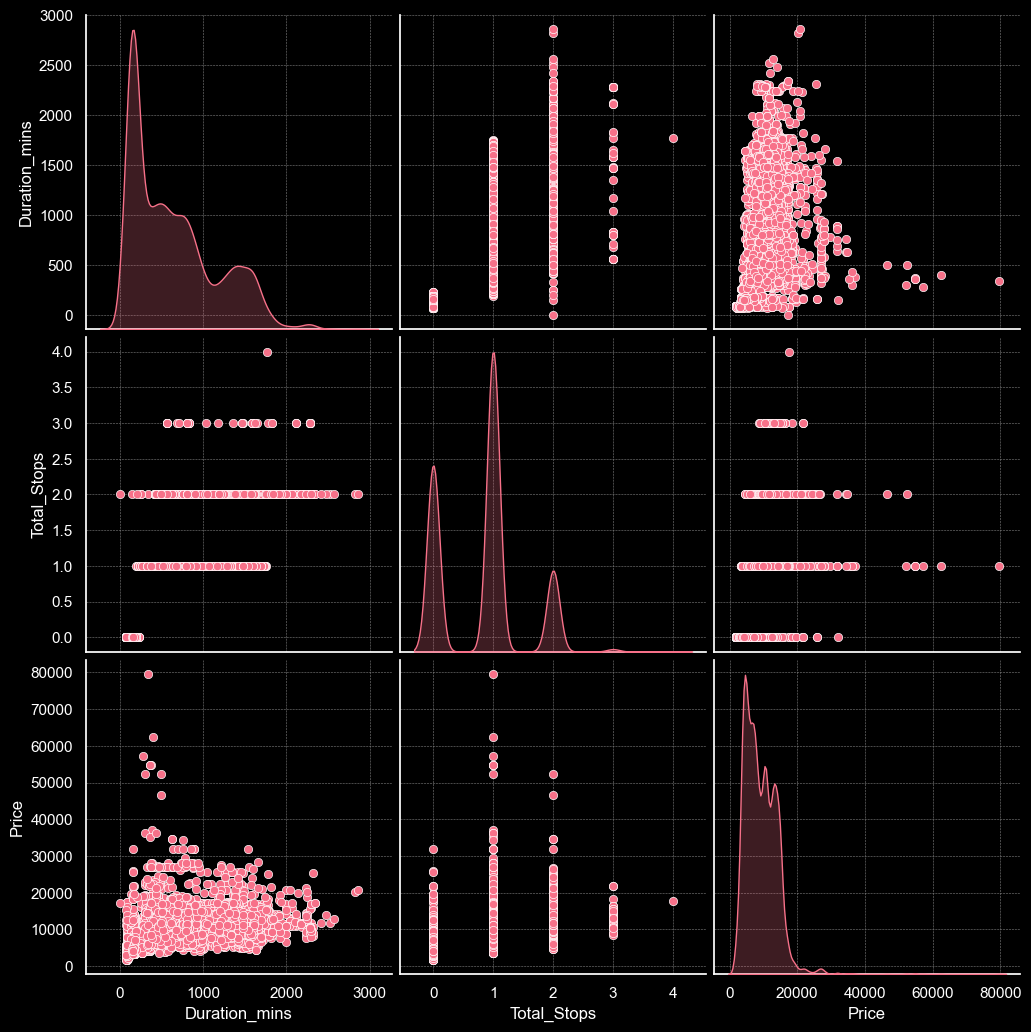

In [34]:
num_cols = ['Duration_mins', 'Total_Stops', 'Price']
sns.set_palette('husl')
sns.pairplot(df[df['is_train'] == 1][num_cols], diag_kind= 'kde',  height= 3.5)
plt.show()

#### Correlation Matrix

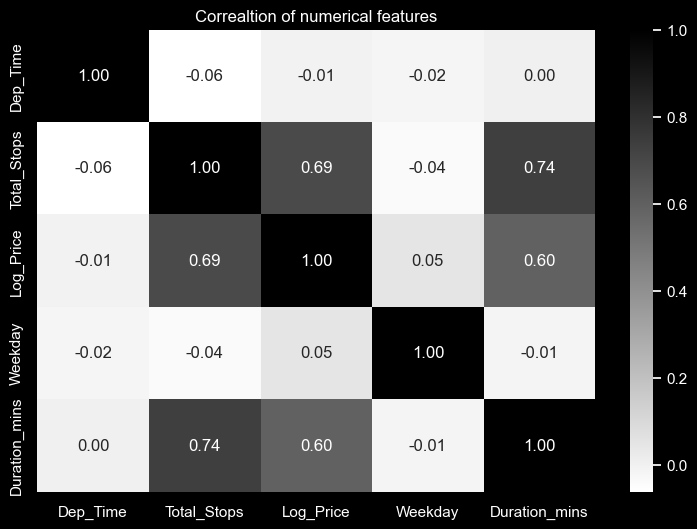

In [35]:
plt.figure(figsize=(9,6))
corr = df[df['is_train'] == 1].drop(columns=['is_train','Price']).corr(numeric_only=True)
sns.heatmap(corr, annot= True, fmt= '.2f', cmap='binary')
plt.title("Correaltion of numerical features")
plt.show()

#### Drop Unnecessary Columns

In [36]:
drop_cols = ['Route', 'Additional_Info', 'Date_of_Journey', 'Duration', 'Arrival_Time', 'is_train', 'Price']
df.drop(columns= drop_cols, inplace= True)

In [37]:
df = df.rename(columns= {'Log_Price':'Price'})

In [38]:
display(style_df(df.head(5)))

,Airline,Source,Destination,Dep_Time,Total_Stops,Price,Month_Period,Weekday,Duration_mins
0,IndiGo,Banglore,New Delhi,22,0,8.268219,2019-03,6,170
1,Air India,Kolkata,Banglore,5,2,8.944159,2019-05,2,445
2,Jet Airways,Delhi,Cochin,9,2,9.538420,2019-06,6,1140
3,IndiGo,Kolkata,Banglore,18,1,8.735364,2019-05,6,325
4,IndiGo,Banglore,New Delhi,16,1,9.495745,2019-03,4,285


#### Data Preprocessing

In [39]:
train_data = df.iloc[:len(train_df) - 1, :]
test_data = df.iloc[len(train_df) - 1 : len(df), :].drop(columns= ['Price'], errors= 'ignore')

In [40]:
display(style_df(train_data.tail()))
display(style_df(test_data.head()))

,Airline,Source,Destination,Dep_Time,Total_Stops,Price,Month_Period,Weekday,Duration_mins
10678,Air Asia,Kolkata,Banglore,19,0,8.320692,2019-04,1,150
10679,Air India,Kolkata,Banglore,20,0,8.329899,2019-04,5,155
10680,Jet Airways,Banglore,Delhi,8,0,8.885994,2019-04,5,180
10681,Vistara,Banglore,New Delhi,11,0,9.445333,2019-03,4,160
10682,Air India,Delhi,Cochin,10,2,9.371949,2019-05,3,500


,Airline,Source,Destination,Dep_Time,Total_Stops,Month_Period,Weekday,Duration_mins
10683,Jet Airways,Delhi,Cochin,17,1,2019-06,3,655
10684,IndiGo,Kolkata,Banglore,6,1,2019-05,6,240
10685,Jet Airways,Delhi,Cochin,19,1,2019-05,1,1425
10686,Multiple carriers,Delhi,Cochin,8,1,2019-05,1,780
10687,Air Asia,Banglore,Delhi,23,0,2019-06,0,170


In [41]:
X = train_data.drop(columns=['Price'])
y = train_data['Price']

In [42]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [43]:
## Train / Test Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size= 0.2, random_state= 42)

#### Custom Preprocessor Pipeline

In [44]:
num_cols = X.select_dtypes(include= [np.number]).columns.tolist()
cat_cols = X.select_dtypes(include= ['object']).columns.tolist()

In [45]:
print(num_cols)
print(cat_cols)

['Dep_Time', 'Total_Stops', 'Weekday', 'Duration_mins']
['Airline', 'Source', 'Destination']


In [46]:
num_pipe = Pipeline([
    ('scaler', RobustScaler())
])

cat_pipe = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

In [47]:
preprocessor = ColumnTransformer([
        ('num', num_pipe, num_cols),
        ('cat', cat_pipe, cat_cols)    
])

#### Baseline Model Using Linear Regression

In [48]:
baseline = Pipeline([
        ('prep', preprocessor),
        ('model', LinearRegression())
])

In [49]:
baseline.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['Dep_Time', 'Total_Stops',
                                                   'Weekday',
                                                   'Duration_mins']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Airline', 'Source',
                                                   'Destination'])])),
                ('model', LinearRegression())])

In [50]:
y_train_pred = baseline.predict(X_train)
y_val_pred = baseline.predict(X_val)

In [51]:
print("Baseline R2-Score (Train Data)", round(r2_score(y_train, y_train_pred),2))
print("Baseline R2-Score (Test Data)", round(r2_score(y_val, y_val_pred),2))
print("\n")
print("Baseline RMSE (Train Data)", round(np.sqrt(mean_squared_error(y_train, y_train_pred)),2))
print("Baseline RMSE (Test Data)", round(np.sqrt(mean_squared_error(y_val, y_val_pred)),2))
print("\n")
print("Baseline MAE (Train Data)", round(mean_absolute_error(y_train, y_train_pred),2))
print("Baseline MAE (Test Data)", round(mean_absolute_error(y_val, y_val_pred),2))

Baseline R2-Score (Train Data) 0.71
Baseline R2-Score (Test Data) 0.71


Baseline RMSE (Train Data) 0.27
Baseline RMSE (Test Data) 0.28


Baseline MAE (Train Data) 0.21
Baseline MAE (Test Data) 0.21


#### Advance Modelling

##### Random Forest

In [93]:
rf_pipe = Pipeline([
        ('prep', preprocessor),
        ('model', RandomForestRegressor(random_state= 42))
])

rf_params = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5]
}

In [96]:
rf_search = RandomizedSearchCV(
    rf_pipe,
    rf_params,
    n_iter= 10,
    cv= 3,
    verbose= 2,
    n_jobs= -1,
    scoring= 'neg_root_mean_squared_error',
    random_state= 42
)

print('Tuning Random Forest...')
rf_search.fit(X_train, y_train)

Tuning Random Forest...
Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('prep',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('scaler',
                                                                                                RobustScaler())]),
                                                                               ['Dep_Time',
                                                                                'Total_Stops',
                                                                                'Weekday',
                                                                                'Duration_mins']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('encoder',
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               ['Airline',
                                                                                'Source',
                                                                                'Destination'])])),
                                             ('model',
                                              RandomForestRegressor(random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'model__max_depth': [None, 10, 20],
                                        'model__min_samples_split': [2, 5],
                                        'model__n_estimators': [100, 200]},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=2)

In [97]:
print("Random Forest Best Params : ", rf_search.best_params_)
print("Best CV RMSE :", -rf_search.best_score_)

Random Forest Best Params :  {'model__n_estimators': 200, 'model__min_samples_split': 5, 'model__max_depth': 10}
Best CV RMSE : 0.24017408645641422


In [98]:
y_train_pred = rf_search.predict(X_train)
y_val_pred = rf_search.predict(X_val)

In [99]:
print("Random Forest R2-Score (Train Data)", round(r2_score(y_train, y_train_pred),2))
print("Random Forest R2-Score (Test Data)", round(r2_score(y_val, y_val_pred),2))
print("\n")
print("Random Forest RMSE (Train Data)", round(np.sqrt(mean_squared_error(y_train, y_train_pred)),2))
print("Random Forest RMSE (Test Data)", round(np.sqrt(mean_squared_error(y_val, y_val_pred)),2))
print("\n")
print("Random Forest MAE (Train Data)", round(mean_absolute_error(y_train, y_train_pred),2))
print("Random Forest MAE (Test Data)", round(mean_absolute_error(y_val, y_val_pred),2))

Random Forest R2-Score (Train Data) 0.84
Random Forest R2-Score (Test Data) 0.79


Random Forest RMSE (Train Data) 0.2
Random Forest RMSE (Test Data) 0.24


Random Forest MAE (Train Data) 0.15
Random Forest MAE (Test Data) 0.17


##### Gradient Boosting

In [58]:
gb_pipe = Pipeline([
        ('prep', preprocessor),
        ('model', GradientBoostingRegressor(random_state= 42))
])

gb_params = {
    'model__n_estimators': [100, 200],
    'model__learning_rate': [0.05, 0.1],
    'model__max_depth': [3, 5]
}

In [59]:
gb_search = RandomizedSearchCV(
    gb_pipe,
    gb_params,
    n_iter= 10,
    cv= 3,
    verbose= 2,
    scoring= 'neg_root_mean_squared_error',
    n_jobs= -1,
    random_state= 42
)

print('Tuning Gradient Boosting...')
gb_search.fit(X_train, y_train)

Tuning Gradient Boosting...
Fitting 3 folds for each of 8 candidates, totalling 24 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('prep',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('scaler',
                                                                                                RobustScaler())]),
                                                                               ['Dep_Time',
                                                                                'Total_Stops',
                                                                                'Weekday',
                                                                                'Duration_mins']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('encoder',
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               ['Airline',
                                                                                'Source',
                                                                                'Destination'])])),
                                             ('model',
                                              GradientBoostingRegressor(random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'model__learning_rate': [0.05, 0.1],
                                        'model__max_depth': [3, 5],
                                        'model__n_estimators': [100, 200]},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=2)

In [60]:
print("Gradient Boosting Best Params : ", gb_search.best_params_)
print("Best CV RMSE :", -gb_search.best_score_)

Gradient Boosting Best Params :  {'model__n_estimators': 200, 'model__max_depth': 5, 'model__learning_rate': 0.1}
Best CV RMSE : 0.23302940763401203


In [61]:
y_train_pred = gb_search.predict(X_train)
y_val_pred = gb_search.predict(X_val)

In [63]:
print("Gradient Boosting R2-Score (Train Data)", round(r2_score(y_train, y_train_pred),2))
print("Gradient Boosting R2-Score (Test Data)", round(r2_score(y_val, y_val_pred),2))
print("\n")
print("Gradient Boosting RMSE (Train Data)", round(np.sqrt(mean_squared_error(y_train, y_train_pred)),2))
print("Gradient Boosting RMSE (Test Data)", round(np.sqrt(mean_squared_error(y_val, y_val_pred)),2))
print("\n")
print("Gradient Boosting MAE (Train Data)", round(mean_absolute_error(y_train, y_train_pred),2))
print("Gradient Boosting MAE (Test Data)", round(mean_absolute_error(y_val, y_val_pred),2))

Gradient Boosting R2-Score (Train Data) 0.85
Gradient Boosting R2-Score (Test Data) 0.81


Gradient Boosting RMSE (Train Data) 0.2
Gradient Boosting RMSE (Test Data) 0.23


Gradient Boosting MAE (Train Data) 0.15
Gradient Boosting MAE (Test Data) 0.17


##### XGBoost

In [84]:
xgb_pipe = Pipeline([
        ('prep', preprocessor),
        ('model', XGBRegressor(objective= 'reg:squarederror' ,random_state= 42))
])

xgb_params = {
    'model__n_estimators': [100, 300, 500, 700],
    'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'model__max_depth': [3, 5, 7, 9],
    'model__min_child_weight': [1, 3, 5, 7],
    'model__subsample': [0.6, 0.8, 1.0],
    'model__colsample_bytree': [0.6, 0.8, 1.0],
    'model__gamma': [0, 0.1, 0.2, 0.5],
    'model__reg_alpha': [0, 0.01, 0.1],
    'model__reg_lambda': [1, 1.5, 2.0]
}

In [89]:
xgb_search = RandomizedSearchCV(
    xgb_pipe,
    xgb_params,
    n_iter= 50,
    cv= 3,
    verbose= 2,
    scoring= 'neg_root_mean_squared_error',
    n_jobs= -1,
    random_state= 42
)

print('Tuning XGBoost...')
xgb_search.fit(X_train, y_train)

Tuning XGBoost...
Fitting 3 folds for each of 50 candidates, totalling 150 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('prep',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('scaler',
                                                                                                RobustScaler())]),
                                                                               ['Dep_Time',
                                                                                'Total_Stops',
                                                                                'Weekday',
                                                                                'Duration_mins']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('encoder',
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               ['Airline',
                                                                                'Source',
                                                                                'Destination'])])),
                                             ('model',
                                              XGBRegressor(base_score=None,
                                                           bo...
                   param_distributions={'model__colsample_bytree': [0.6, 0.8,
                                                                    1.0],
                                        'model__gamma': [0, 0.1, 0.2, 0.5],
                                        'model__learning_rate': [0.01, 0.05,
                                                                 0.1, 0.2],
                                        'model__max_depth': [3, 5, 7, 9],
                                        'model__min_child_weight': [1, 3, 5, 7],
                                        'model__n_estimators': [100, 300, 500,
                                                                700],
                                        'model__reg_alpha': [0, 0.01, 0.1],
                                        'model__reg_lambda': [1, 1.5, 2.0],
                                        'model__subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=2)

In [90]:
print("XGBoost Best Params : ", xgb_search.best_params_)
print("Best CV RMSE :", -xgb_search.best_score_)

XGBoost Best Params :  {'model__subsample': 1.0, 'model__reg_lambda': 1, 'model__reg_alpha': 0.1, 'model__n_estimators': 300, 'model__min_child_weight': 3, 'model__max_depth': 7, 'model__learning_rate': 0.05, 'model__gamma': 0, 'model__colsample_bytree': 0.6}
Best CV RMSE : 0.2316745976022809


In [91]:
y_train_pred = xgb_search.predict(X_train)
y_val_pred = xgb_search.predict(X_val)

In [92]:
print("XGBoost R2-Score (Train Data)", round(r2_score(y_train, y_train_pred),2))
print("XGBoost R2-Score (Test Data)", round(r2_score(y_val, y_val_pred),2))
print("\n")
print("XGBoost RMSE (Train Data)", round(np.sqrt(mean_squared_error(y_train, y_train_pred)),2))
print("XGBoost RMSE (Test Data)", round(np.sqrt(mean_squared_error(y_val, y_val_pred)),2))
print("\n")
print("XGBoost MAE (Train Data)", round(mean_absolute_error(y_train, y_train_pred),2))
print("XGBoost MAE (Test Data)", round(mean_absolute_error(y_val, y_val_pred),2))

XGBoost R2-Score (Train Data) 0.86
XGBoost R2-Score (Test Data) 0.81


XGBoost RMSE (Train Data) 0.19
XGBoost RMSE (Test Data) 0.22


XGBoost MAE (Train Data) 0.14
XGBoost MAE (Test Data) 0.16


### Best Model Performance

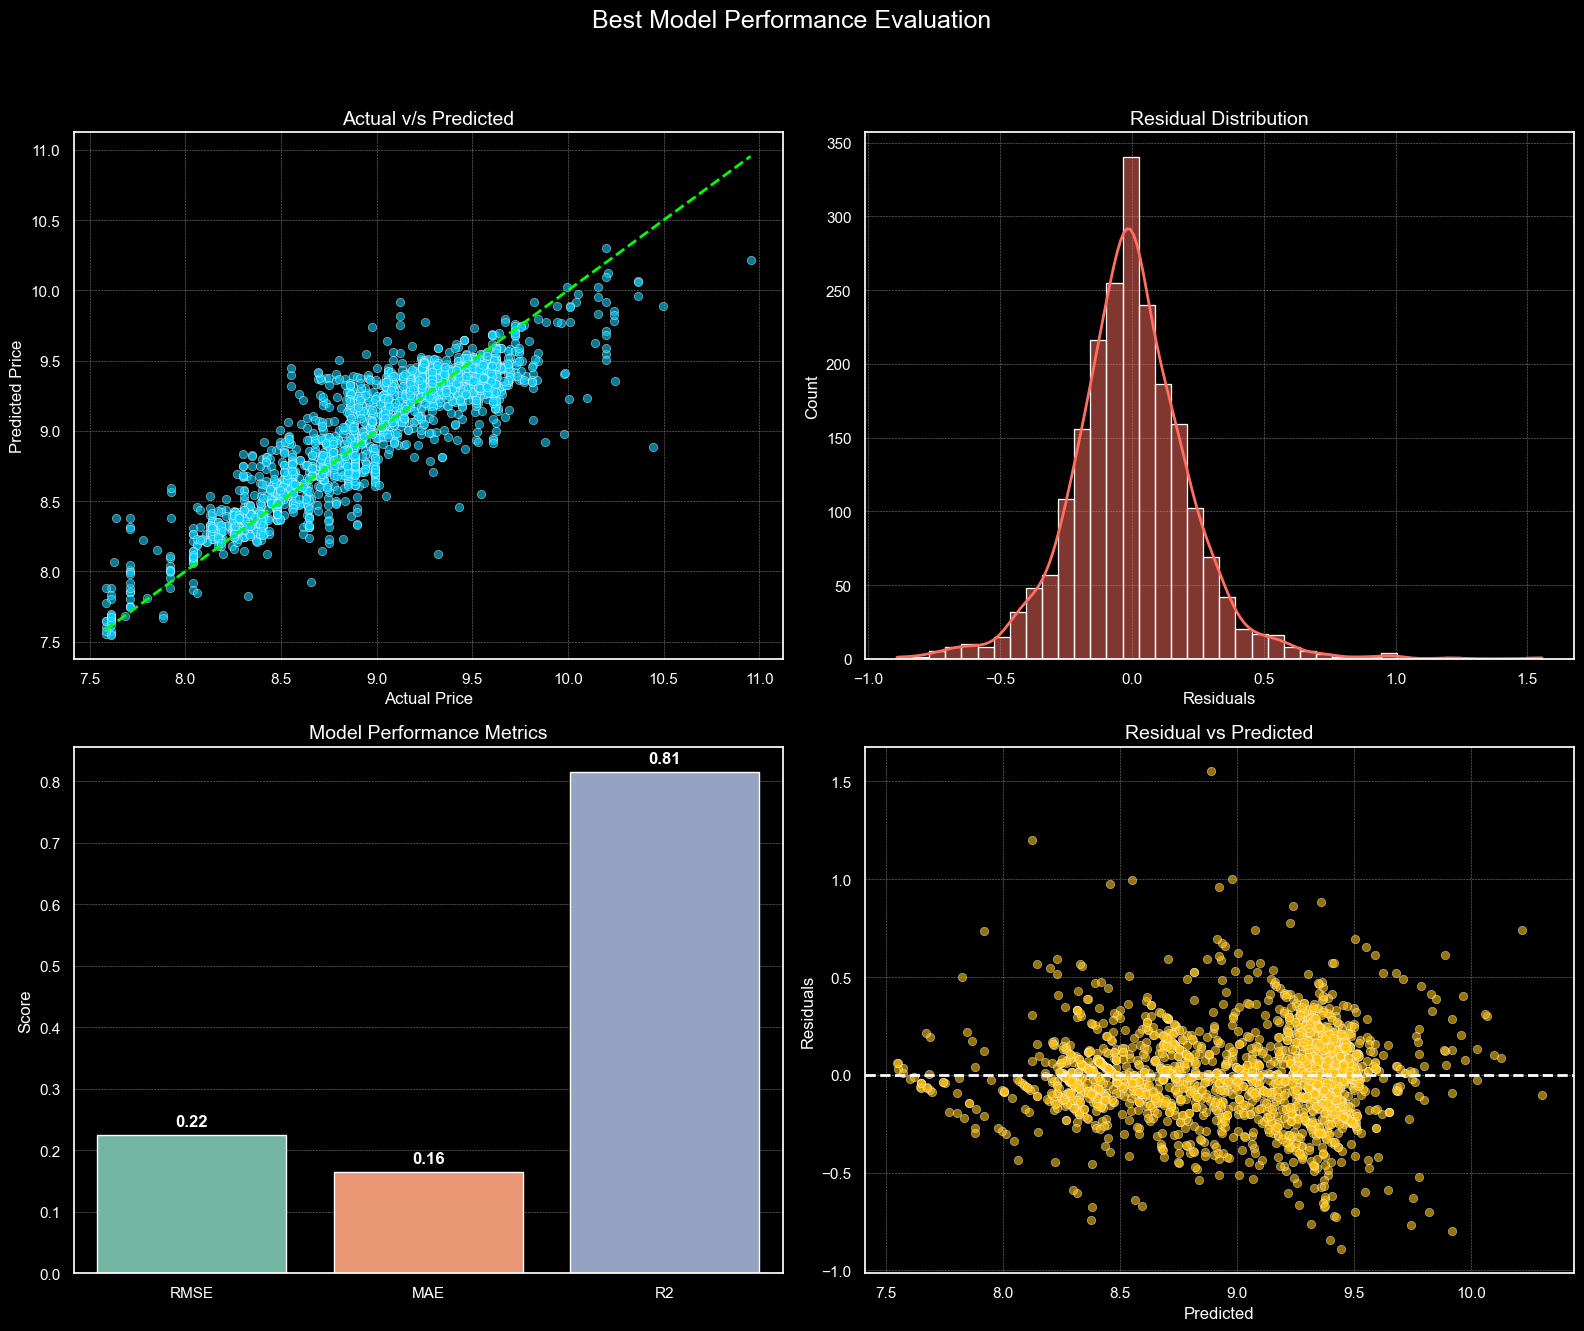

In [101]:
best_model = xgb_search.best_estimator_
y_pred = best_model.predict(X_val)
residuals = y_val - y_pred

fig, axes = plt.subplots(2, 2, figsize= (16, 14))
fig.suptitle("Best Model Performance Evaluation", fontsize= 18, color= 'white')

## 1. Actual & Predicted
sns.scatterplot(ax= axes[0,0], x= y_val, y= y_pred, color= '#00d0ff', alpha= 0.6)
sns.lineplot(ax= axes[0,0], x= y_val, y= y_val, color= 'lime', linestyle= "--")
axes[0,0].set_title("Actual v/s Predicted", fontsize=14, color= 'white')
axes[0,0].set_xlabel("Actual Price")
axes[0,0].set_ylabel("Predicted Price")

## 2. Residual Distribution
sns.histplot(residuals, bins= 40, kde= True, ax= axes[0,1], color= "#ff6f61")
axes[0,1].set_title("Residual Distribution", fontsize=14, color= 'white')
axes[0,1].set_xlabel("Residuals")

## 3. Metrics Bar Plot
metrics = {
    'RMSE': np.sqrt(mean_squared_error(y_val, y_pred)),
    'MAE': mean_absolute_error(y_val, y_pred),
    'R2': r2_score(y_val, y_pred)
}
barplot = sns.barplot(
    ax=axes[1, 0],
    x=list(metrics.keys()),
    y=list(metrics.values()),
    palette='Set2'
)

for i, (label, value) in enumerate(metrics.items()):
    barplot.text(i, value + 0.01, f'{value:.2f}', ha='center', va='bottom', color='white', fontweight='bold')

axes[1, 0].set_title("Model Performance Metrics", fontsize=14, color='white')
axes[1, 0].set_ylabel("Score")
axes[1, 0].tick_params(colors='white')
axes[1, 0].spines['bottom'].set_color('white')
axes[1, 0].spines['left'].set_color('white')

## 4. Residuals vs Predicted
sns.scatterplot(ax= axes[1,1], x= y_pred, y= residuals, color= '#ffc107', alpha= 0.6)
axes[1,1].axhline(0, color= 'white', linestyle= "--")
axes[1,1].set_title("Residual vs Predicted", fontsize=14, color= 'white')
axes[1,1].set_xlabel("Predicted")
axes[1,1].set_ylabel("Residuals")

plt.tight_layout(rect= [0, 0.03, 1, 0.95])
plt.show()

### Insights:
---

### 📈 1. **Actual vs Predicted Plot (Top-Left)**

* **Insight:** The points closely follow the green diagonal line, indicating that the model is predicting quite well — actual values are well-aligned with predicted values.
* **Deviation:** Some dispersion is visible, especially for higher actual prices, suggesting slight under- or over-prediction in those regions.
* **Conclusion:** High correlation between actual and predicted prices; model generalizes well overall.

---

### 📊 2. **Residual Distribution (Top-Right)**

* **Insight:** The residuals are roughly centered around zero and follow a **bell-shaped curve**, indicating that the model’s errors are fairly normally distributed.
* **Slight Skewness:** There is a tiny skew (possibly right), meaning a few predictions are slightly underestimated.
* **Conclusion:** Good sign — errors are mostly unbiased and homoscedastic.

---

### 📉 3. **Model Performance Metrics Bar Plot (Bottom-Left)**

* **RMSE:** \~0.22
* **MAE:** \~0.16
* **R² Score:** \~0.81
* **Insight:**

  * **R² = 0.81** means **81% of variance** in the target variable is explained by the model.
  * Low **RMSE** and **MAE** reflect low prediction error magnitudes.
* **Conclusion:** The model is **strong and reliable** with high predictive power.

---

### 🔍 4. **Residuals vs Predicted Plot (Bottom-Right)**

* **Insight:** Residuals are scattered evenly across predicted values, mostly within ±0.5 range.
* **No Clear Pattern:** Suggests **no major heteroscedasticity** or model bias.
* **Minor Observations:**

  * A slight clustering around specific predicted values might suggest feature influence or price band saturation.
* **Conclusion:** Errors are randomly distributed → another sign of a **well-fitted model**.

---

### ✅ **Final Summary**

* ✅ **Strong Predictive Accuracy** with R² = 0.81.
* ✅ **Balanced and Normally Distributed Residuals** → low bias.
* ✅ **Minimal Overfitting Signs** → good generalization.
* ✅ **Good model fit** shown in actual vs predicted and residuals plots.

---

### Predict on Test Set

In [103]:
test_preds = best_model.predict(test_data)

In [104]:
test_df.drop(columns=['is_train'], inplace= True)

In [111]:
acutal_preds = np.expm1(test_preds)
test_df['Prediction Price'] = acutal_preds

In [112]:
display(style_df(test_df.head()))

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Prediction Price
0,Jet Airways,6/06/2019,Delhi,Cochin,DEL ? BOM ? COK,17:30,04:25 07 Jun,10h 55m,1 stop,No info,10436.073242
1,IndiGo,12/05/2019,Kolkata,Banglore,CCU ? MAA ? BLR,06:20,10:20,4h,1 stop,No info,4992.979492
2,Jet Airways,21/05/2019,Delhi,Cochin,DEL ? BOM ? COK,19:15,19:00 22 May,23h 45m,1 stop,In-flight meal not included,12639.800781
3,Multiple carriers,21/05/2019,Delhi,Cochin,DEL ? BOM ? COK,08:00,21:00,13h,1 stop,No info,10557.087891
4,Air Asia,24/06/2019,Banglore,Delhi,BLR ? DEL,23:55,02:45 25 Jun,2h 50m,non-stop,No info,4442.364258


<div align="center">

### Thank You

</div>